In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Metrics and evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance

# Machine learning models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

# Visualization tools
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns

# TensorFlow/Keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model

#Model saving and loading
import pickle
import json
from tensorflow.keras.models import model_from_json


2025-02-09 12:39:52.840498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-09 12:39:53.042728: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load and clean data

In [2]:
# Install gdown if not already installed
!pip install gdown --quiet
import gdown

# Define the file ID and destination filename
file_id = "1EZRAZpcxKjXjFw0u2LsbMaJ0HqEquO8g"
destination = "MiningProcess_Flotation_Plant_Database.csv"  # Name the file as specified

# Use gdown to download the file

gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip


Downloading...
From (original): https://drive.google.com/uc?id=1EZRAZpcxKjXjFw0u2LsbMaJ0HqEquO8g
From (redirected): https://drive.google.com/uc?id=1EZRAZpcxKjXjFw0u2LsbMaJ0HqEquO8g&confirm=t&uuid=17e7d83b-dafa-4dd9-9bdc-3f4a25b11481
To: /home/nicole/code/nicole-baltodano/Mining/MiningProcess_Flotation_Plant_Database.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 184M/184M [00:05<00:00, 31.3MB/s]


'MiningProcess_Flotation_Plant_Database.csv'

In [3]:
# Load the CSV file into a Pandas DataFrame
data = pd.read_csv(destination,decimal=',')
data['date'] = pd.to_datetime(data['date'])
print("File successfully downloaded and loaded into a DataFrame!")

File successfully downloaded and loaded into a DataFrame!


In [4]:
data.dtypes

date                            datetime64[ns]
% Iron Feed                            float64
% Silica Feed                          float64
Starch Flow                            float64
Amina Flow                             float64
Ore Pulp Flow                          float64
Ore Pulp pH                            float64
Ore Pulp Density                       float64
Flotation Column 01 Air Flow           float64
Flotation Column 02 Air Flow           float64
Flotation Column 03 Air Flow           float64
Flotation Column 04 Air Flow           float64
Flotation Column 05 Air Flow           float64
Flotation Column 06 Air Flow           float64
Flotation Column 07 Air Flow           float64
Flotation Column 01 Level              float64
Flotation Column 02 Level              float64
Flotation Column 03 Level              float64
Flotation Column 04 Level              float64
Flotation Column 05 Level              float64
Flotation Column 06 Level              float64
Flotation Col

In [5]:
#missing hours in the date column 

# Create a complete range of hourly timestamps
full_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='H')

# Create a DataFrame from the full range
full_range_df = pd.DataFrame(full_range, columns=['date'])

# Merge the full range with actual data to identify missing hours
merged = full_range_df.merge(data, on='date', how='left', indicator=True)

# Identify missing hours
missing_hours = merged[merged['_merge'] == 'left_only']['date']

# Extract the days that are missing hours
missing_days = missing_hours.dt.date.unique()

print("Days Missing Hours:")
for day in missing_days:
    print(f"Date: {day}")
    day_missing_hours = missing_hours[missing_hours.dt.date == day]
    print(f"Missing Hours: {day_missing_hours.dt.hour.values}")
    print()

/tmp/ipykernel_1828/1613406208.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='H')


Days Missing Hours:
Date: 2017-03-16
Missing Hours: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-17
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-18
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-19
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-20
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-21
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-22
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-23
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-24
Missing Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Date: 2017-03-25
Missing Hours: [ 0

In [6]:
# Seems like the plant when in to shut down from 2017-03-16 to 2017-03-29
#We are going to work only with data after 2017-03-29 11 pm since LSTM is time dependent
df = data.copy()
df.set_index('date',inplace=True)
df = df[df.index > '2017-03-29 11:00:00']

## Resample by hour
df=df.resample('H').mean()

/tmp/ipykernel_1828/312268246.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df=df.resample('H').mean()


In [7]:
df

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,60.18,9.34,1060.859297,379.836203,400.982539,9.527187,1.550374,200.035839,195.577700,199.983717,...,249.992956,753.724247,726.559437,860.557818,477.349197,452.512522,478.219647,470.105547,66.44,1.36
2017-03-29 13:00:00,60.18,9.34,2034.926525,322.233975,400.468947,9.700679,1.532017,199.990122,195.106250,199.765344,...,250.059711,848.675503,777.784437,869.419421,483.816131,469.448172,471.607075,462.665478,66.57,1.43
2017-03-29 14:00:00,60.18,9.34,1435.425811,474.656322,399.157083,9.687788,1.645200,200.019311,195.604928,199.925800,...,250.111328,851.951492,776.293654,879.704989,456.147231,453.227000,447.708467,453.475667,66.64,1.33
2017-03-29 15:00:00,60.18,9.34,618.460387,396.377733,398.942522,9.851689,1.559929,199.940833,195.657094,200.044339,...,250.028506,855.910630,780.369869,882.093896,449.410744,448.581506,450.697578,448.660094,66.41,1.27
2017-03-29 16:00:00,59.54,9.56,1367.502858,317.134072,400.836283,9.936163,1.530984,199.878922,196.162864,199.905467,...,250.122067,851.603513,784.446084,884.840698,450.123050,451.774694,451.574422,449.406894,63.63,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,3327.047776,497.211189,380.847200,9.176166,1.660871,301.565561,300.169133,299.900722,...,298.736661,397.781583,498.753311,403.858956,398.930467,502.971728,399.468911,400.559511,65.05,1.65
2017-09-09 20:00:00,49.75,23.20,4225.800333,508.963856,381.112889,9.387541,1.691996,300.050172,299.967839,299.906550,...,303.599269,399.928567,499.648950,399.208611,399.967122,501.624533,398.905006,400.486233,64.83,1.71
2017-09-09 21:00:00,49.75,23.20,2808.214692,517.748822,381.064411,9.771277,1.735647,299.814289,299.801561,299.973161,...,309.875439,399.961433,500.484917,471.827489,399.931033,500.223311,401.899806,400.556333,64.29,1.80


In [8]:
df.isna().sum()

% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

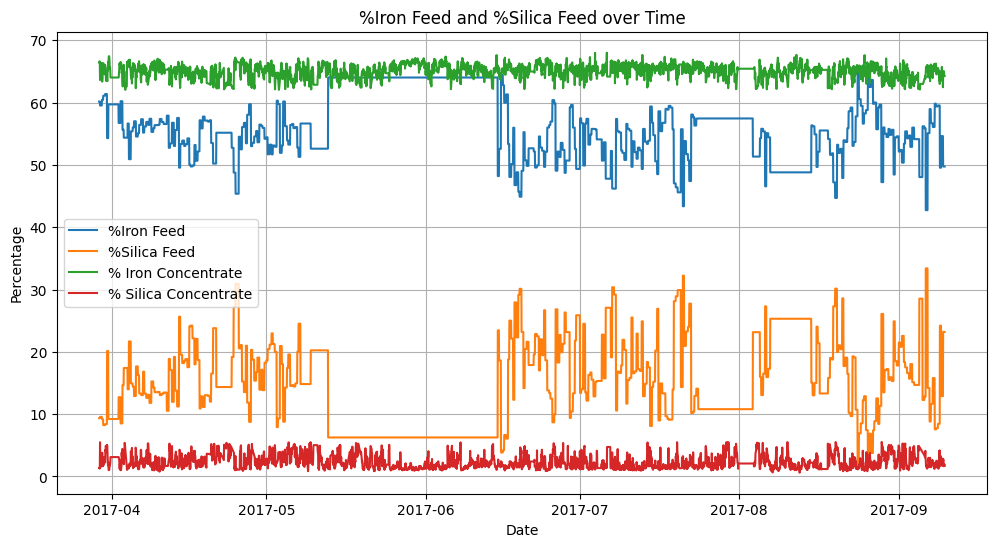

In [9]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['% Iron Feed'], label='%Iron Feed')
plt.plot(df.index, df['% Silica Feed'], label='%Silica Feed')
plt.plot(df.index, df['% Iron Concentrate'], label='% Iron Concentrate')
plt.plot(df.index, df['% Silica Concentrate'], label='% Silica Concentrate')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('%Iron Feed and %Silica Feed over Time')
plt.legend()
plt.grid(True)
plt.show()

# Feature selection and preparation for LSTM model

In [10]:

def select_features(data, target_column, corr_threshold=0.1, collinearity_threshold=0.9):
    """
    Select features by dropping those with low correlation to the target
    and high multicollinearity.

    Parameters:
    - data: DataFrame containing the dataset.
    - target_column: Name of the target column as a string.
    - corr_threshold: Minimum absolute correlation with the target to retain a feature.
    - collinearity_threshold: Maximum pairwise correlation between features.

    Returns:
    - reduced_data: DataFrame with selected features.
    - dropped_features: List of features dropped during selection.
    """
    # Step 1: Calculate correlation with the target
    target_corr = data.corr()[target_column].drop(target_column)  # Exclude target
    high_corr_features = target_corr[abs(target_corr) >= corr_threshold].index.tolist()

    # Step 2: Filter dataset to include only features with high correlation to the target
    filtered_data = data[high_corr_features + [target_column]]
    
    # Step 3: Check for multicollinearity (pairwise feature correlation)
    corr_matrix = filtered_data.corr().abs()
    dropped_features = set()

    for feature in high_corr_features:
        if feature in dropped_features:
            continue
        # Find features highly correlated with the current feature
        high_corr_with_feature = corr_matrix[feature][corr_matrix[feature] > collinearity_threshold].index.tolist()
        # Exclude the current feature and add others to the drop list
        high_corr_with_feature.remove(feature)
        dropped_features.update(high_corr_with_feature)

    # Step 4: Remove highly correlated features
    final_features = [f for f in high_corr_features if f not in dropped_features]
    reduced_data = data[final_features + [target_column]]

    return reduced_data, list(dropped_features)


# Example Usage:
# Assuming `df` is your DataFrame and `% Silica Concentrate` is the target
target_column = '% Silica Concentrate'
selected_data, dropped_features = select_features(df, target_column, corr_threshold=0.1, collinearity_threshold=0.9)

print("Selected Features:\n", selected_data.columns.tolist())
print("Dropped Features:\n", dropped_features)


Selected Features:
 ['Amina Flow', 'Ore Pulp pH', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level', '% Iron Concentrate', '% Silica Concentrate']
Dropped Features:
 ['Flotation Column 03 Air Flow']


In [11]:
df=df[selected_data.columns.tolist()]

In [12]:
# Interaction between air flows and pulp pH.
df['Air_pH_Interaction'] = df['Flotation Column 01 Air Flow'] * df['Ore Pulp pH']

/tmp/ipykernel_1828/905757716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Air_pH_Interaction'] = df['Flotation Column 01 Air Flow'] * df['Ore Pulp pH']


In [13]:
# Calculate split sizes
train_size = int(len(df) * 0.7)  # 70% for training
val_size = int(len(df) * 0.15)   # 15% for validation

# Split the dataset
df_train = df.iloc[:train_size]  # First 70% for training
df_val = df.iloc[train_size:train_size + val_size]  # Next 15% for validation
df_test = df.iloc[train_size + val_size:]  # Remaining 15% for testing

# Print dataset sizes
print(f"📊 Train Size: {len(df_train)}, Validation Size: {len(df_val)}, Test Size: {len(df_test)}")

📊 Train Size: 2763, Validation Size: 592, Test Size: 593


In [14]:
# Normalize data
scaler = MinMaxScaler()

df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=scaler.get_feature_names_out())
df_val = pd.DataFrame(scaler.transform(df_val), columns=scaler.get_feature_names_out())
df_test = pd.DataFrame(scaler.transform(df_test), columns=scaler.get_feature_names_out())


In [15]:

def window_slicing(n_hours,df):
    
    # Prepare the dataset
    X, y = [], []

    # Iterate over the dataframe to create sequences
    for i in range(len(df) - n_hours):
        # Get the input sequence
        X_sequence = df.iloc[i:i + n_hours].values
        # Get the target value for the next hour
        #y_sequence = df.iloc[i + n_hours][['% Silica Concentrate','% Iron Concentrate']].values
        y_sequence = df.iloc[i + n_hours][['% Silica Concentrate']].values
        X.append(X_sequence)
        y.append(y_sequence)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    y=np.expand_dims(y, axis=1)

    return X, y


# LSTM Model

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

def create_lstm_model(initial_learning_rate, decay_steps, decay_rate,neurons,input_shape):

     # Input layer
    inputs = Input(shape=input_shape)
    
    # Shared LSTM layers with regularization
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=True)(inputs)
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=True)(x)
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=True)(x)
    
    x = LSTM(units=neurons, activation='tanh', return_sequences=False)(x)

    
        # Separate output layers for each target
    output = Dense(1, activation='linear', name='output')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=output)
    

    lr_schedule = ExponentialDecay(
    initial_learning_rate, 
    decay_steps = decay_steps, 
    decay_rate = decay_rate)
    
    # Using Adam optimizer 
    optimizer = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [17]:
def fit_model(df_train,df_test,seq_length,validation_split,batch_size,epochs, initial_learning_rate,decay_steps,decay_rate,neurons):
    
        #train data
    X_train,y_train = window_slicing(seq_length,df_train)
    
    shape = (X_train.shape[1],X_train.shape[2])
    
        # Create the model
    model = create_lstm_model(initial_learning_rate, decay_steps, decay_rate,neurons,input_shape=shape)


    
    # train the LSTM model

    es = EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=validation_split,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=[es],
                        verbose=1)
    
    X_test, y_test = window_slicing(seq_length,df_test)
    
    return history,model, X_test, y_test

# Fine-tunning

In [18]:
# This section requires a lot of computation power, can be skipped by directly loading the model 

In [19]:
# Define parameter grids using dictionaries
param_grid = {
    'seq_length': [3,6,12],
    'validation_split': [0.2, 0.3],
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'initial_learning_rate': [0.01, 0.001],
    'decay_steps': [1000, 2000],
    'decay_rate': [0.01, 0.001],
    'neurons': [30, 50,100]
}

#576 possible combinations


In [20]:
## You can skip this step and directly load the model

In [21]:
# Get keys and values from param_grid
param_names = list(param_grid.keys())
param_values = list(param_grid.values())

# Create iterator over all parameter combinations
param_combinations = itertools.product(*param_values)

# Path to save best parameters
best_params_path = "best_lstm_params.json"

best_r2_score = -float('inf')
best_params = None

n=0

# Iterate over parameter combinations
for values in param_combinations:
    params = dict(zip(param_names, values))
     
    history, model, X_test, y_test = fit_model(df_train, df_val, **params)
    
    # Calculate R^2 score
    y_test_flat = y_test.reshape(-1, 1)
    pred = model.predict(X_test)
    r2 = r2_score(y_test_flat, pred)
    
    print(f"R^2 Score: {r2}")
    
    # If it's the best model, save the parameters
    if r2 > best_r2_score:
        best_r2_score = r2
        best_params = params
        
        # Save best parameters to a JSON file
        import json
        with open(best_params_path, "w") as f:
            json.dump(best_params, f)
        
        print(f"✅ Best parameters saved: {best_params}")


    n=n+1
        # Break the loop if n > 300
    if n > 300:
        print("Stopping training as n exceeds 300.")
        break
        
# Print the best parameters found
print("Best Parameters:")
print(best_params)
print(f"Best R^2 Score: {best_r2_score}")

2025-02-09 12:40:08.063592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
138/138 [==============================] - 4s 12ms/step - loss: 0.0460 - mae: 0.1647 - val_loss: 0.0361 - val_mae: 0.1631
Epoch 2/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0265 - mae: 0.1218 - val_loss: 0.0271 - val_mae: 0.1218
Epoch 3/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0219 - mae: 0.1063 - val_loss: 0.0232 - val_mae: 0.1041
Epoch 4/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0215 - mae: 0.1041 - val_loss: 0.0232 - val_mae: 0.1017
Epoch 5/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0211 - mae: 0.1034 - val_loss: 0.0236 - val_mae: 0.0991
Epoch 6/50
138/138 [==============================] - 1s 7ms/step - loss: 0.0209 - mae: 0.1020 - val_loss: 0.0234 - val_mae: 0.1028
Epoch 7/50
138/138 [==============================] - 1s 6ms/step - loss: 0.0208 - mae: 0.1016 - val_loss: 0.0233 - val_mae: 0.1019
Epoch 8/50
138/138 [==============================] - 1s 6ms/step - loss: 0

KeyboardInterrupt: 

# Load best parameters and predict

In [47]:


# Path to save best parameters
best_params_path = "best_lstm_params.json"

# Load best parameters
with open(best_params_path, "r") as f:
    best_params = json.load(f)

print(f"🚀 Using Best Parameters: {best_params}")

# Train the model again with best parameters
history, best_model, X_test, y_test = fit_model(df_train, df_test, **best_params)

# Make predictions
pred = best_model.predict(X_test)
y_test_flat = y_test.reshape(-1, 1)

r1 = r2_score(y_test_flat, pred)

# Compute R^2 Score

r1 = r2_score(y_test.reshape(-1, 1), pred)
print("Restored Model R^2 Score:", r1)


🚀 Using Best Parameters: {'seq_length': 6, 'validation_split': 0.2, 'batch_size': 16, 'epochs': 50, 'initial_learning_rate': 0.01, 'decay_steps': 2000, 'decay_rate': 0.001, 'neurons': 30}
Epoch 1/50
138/138 [==============================] - 5s 16ms/step - loss: 0.0438 - mae: 0.1618 - val_loss: 0.0333 - val_mae: 0.1566
Epoch 2/50
138/138 [==============================] - 1s 10ms/step - loss: 0.0231 - mae: 0.1118 - val_loss: 0.0235 - val_mae: 0.1042
Epoch 3/50
138/138 [==============================] - 1s 10ms/step - loss: 0.0222 - mae: 0.1080 - val_loss: 0.0270 - val_mae: 0.1085
Epoch 4/50
138/138 [==============================] - 1s 11ms/step - loss: 0.0214 - mae: 0.1044 - val_loss: 0.0235 - val_mae: 0.1052
Epoch 5/50
138/138 [==============================] - 1s 10ms/step - loss: 0.0207 - mae: 0.1021 - val_loss: 0.0240 - val_mae: 0.1010
Epoch 6/50
138/138 [==============================] - 1s 11ms/step - loss: 0.0206 - mae: 0.1012 - val_loss: 0.0242 - val_mae: 0.1032
Epoch 7/50
138

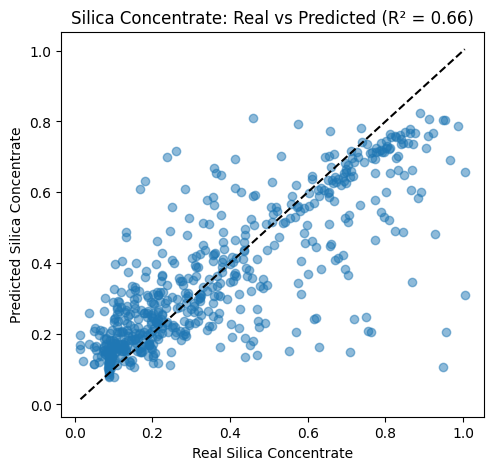

In [48]:
# Scatter plots
plt.figure(figsize=(12, 5))

# Scatter plot for target
plt.subplot(1, 2, 1)
plt.scatter(y_test_flat, pred, alpha=0.5)
plt.xlabel('Real Silica Concentrate')
plt.ylabel('Predicted Silica Concentrate')
plt.title(f'Silica Concentrate: Real vs Predicted (R² = {r1:.2f})')
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(),y_test_flat.max()], 'k--')


In [41]:
#Getting all y values transformed to compare with predictions
df_transform = pd.DataFrame(scaler.fit_transform(df), columns=scaler.get_feature_names_out())
X,y = window_slicing(best_params['seq_length'],df_transform)
y_flat = y.reshape(-1, 1)

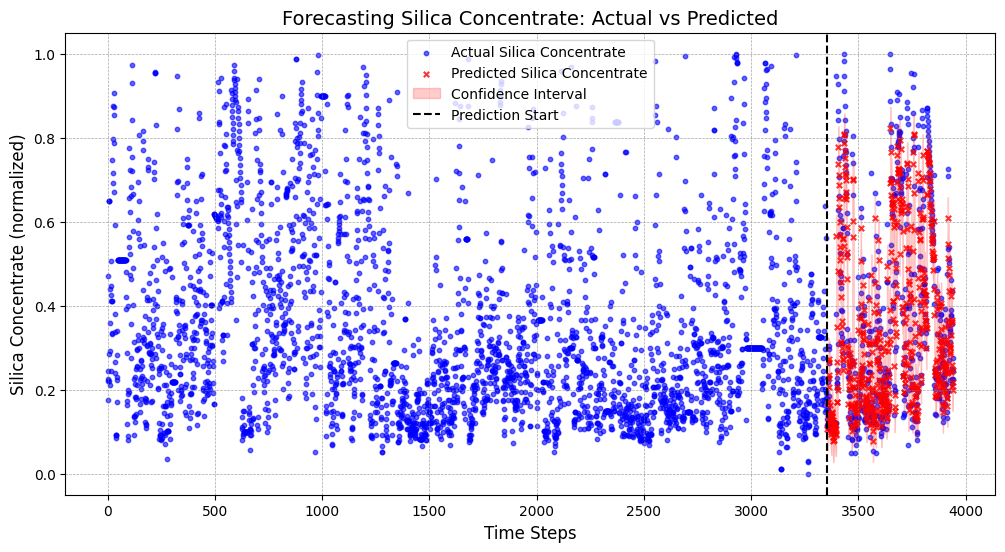

In [64]:
# Ensure predictions and bounds are 1D
pred = pred.ravel()
lower_bound = pred - 0.05
upper_bound = pred + 0.05

# Define x-axis range
x_actual = np.arange(len(y_flat))
x_pred = np.arange(len(y_flat) - len(pred), len(y_flat))

plt.figure(figsize=(12, 6))

# Scatter plots
plt.scatter(x_actual, y_flat, label="Actual Silica Concentrate", color="blue", alpha=0.6, s=10, marker="o")
plt.scatter(x_pred, pred, label="Predicted Silica Concentrate", color="red", alpha=0.8, s=15, marker="x")

# Confidence interval
plt.fill_between(x_pred, lower_bound, upper_bound, color="red", alpha=0.2, label="Confidence Interval")

# Add vertical line to indicate prediction start
plt.axvline(len(y_flat) - len(pred), color="black", linestyle="--", label="Prediction Start")

# Add grid, labels, and title
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Silica Concentrate (normalized)", fontsize=12)
plt.title("Forecasting Silica Concentrate: Actual vs Predicted", fontsize=14)
plt.legend()
plt.show()

